In [3]:
# Dependencies
import tweepy
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime
import datetime
import time
import seaborn as sns
import pandas_datareader.data as web

In [4]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [5]:
# Twitter API Keys
from config import consumer_key, consumer_secret, \
    access_token, access_token_secret

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [6]:
# Filters
min_tweets = 5
lang = "en"

In [7]:
# Search terms
search_terms = ["$FB", "$AAPL", "$AMZN", "$NFLX", "$GOOG", "$GLD"]
search_terms1 = ["FB","AAPL","AMZN","NFLX","GOOG","GLD"]

# target_users = "@cnbc " or "@benzinga" or "@stocktwits"

# target_users = "@cnbc " or "@benzinga" or "@stocktwits" or "@breakoutstocks" \
#               or "@bespokeinvest" or "@WSJMarkets" or "@stephanie_link" or \
#              "@nytimesbusiness" or "@IBDinvestors " or "@WSJDealJournal"

In [8]:
# Date and time range
start = datetime.datetime(2018, 3, 5)
end = datetime.datetime(2018, 3, 9)

# Get Stock Data from Morningstar
stock_data = web.DataReader(search_terms1, "morningstar", start, end)

# Put Open and Close Data into Pandas DataFrame
df = pd.DataFrame(stock_data)[["Open", "Close"]]
df.head()

Open   Close
Symbol Date                      
FB     2018-03-05  176.20  180.40
       2018-03-06  181.78  179.78
       2018-03-07  178.74  183.71
       2018-03-08  183.56  182.34
       2018-03-09  183.91  185.23

In [9]:
df["Diff"] = df["Close"] - df["Open"]
#df.head()

df["Percent_Diff"] = (df["Diff"]/df["Open"])*100
df.head()

Open   Close  Diff  Percent_Diff
Symbol Date                                          
FB     2018-03-05  176.20  180.40  4.20      2.383655
       2018-03-06  181.78  179.78 -2.00     -1.100231
       2018-03-07  178.74  183.71  4.97      2.780575
       2018-03-08  183.56  182.34 -1.22     -0.664633
       2018-03-09  183.91  185.23  1.32      0.717742

In [10]:
# Calculate total stock price change within the date specified
df1 = df.groupby("Symbol")["Percent_Diff"].sum()
df1

Symbol
AAPL    2.240452
AMZN    4.570065
FB      4.117109
GLD    -0.004848
GOOG    6.041508
NFLX    7.576157
Name: Percent_Diff, dtype: float64

In [11]:
# Add data to Pandas DataFrame
df_df = pd.DataFrame(df1)
df_df

,Percent_Diff
Symbol,
AAPL,2.240452
AMZN,4.570065
FB,4.117109
GLD,-0.004848
GOOG,6.041508
NFLX,7.576157


In [12]:
# Reset index
diff_df = df_df.reset_index(drop = False)
diff_df

,Symbol,Percent_Diff
0,AAPL,2.240452
1,AMZN,4.570065
2,FB,4.117109
3,GLD,-0.004848
4,GOOG,6.041508
5,NFLX,7.576157


In [13]:
# Variables for holding sentiments
sentiments = []

In [14]:
# Date Range
startdate = datetime.datetime(2018, 3, 5, 0, 0, 0)
enddate = datetime.datetime(2018, 3, 9, 0, 0, 0)

# Loop through all search terms
for term in search_terms:
    
    counter = 1
    
    public_tweets = api.search(term, count = 200, since = startdate, until = enddate)
    
    for tweet in public_tweets["statuses"]:
        
        # Filter tweets
        if (tweet["user"]["statuses_count"] > min_tweets and
            tweet["user"]["lang"] == lang):
        
            # Run Vader Analysis on each tweets
            compound = analyzer.polarity_scores(tweet["text"])["compound"]
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            tweets_ago = counter

            # Add sentiments for each tweets into an array
            sentiments.append({"Compound": compound,
                               "Positive": pos,
                               "Neutral": neu,
                               "Negative": neg,
                               "Tweets Ago": counter,
                               "Symbol": term,
                               "Date": tweet["created_at"],
                               "Tweet Text": tweet["text"]})

        # Add to counter
        counter = counter + 1
        
sentiments

[{'Compound': 0.0,
  'Date': 'Thu Mar 08 23:25:53 +0000 2018',
  'Negative': 0.0,
  'Neutral': 1.0,
  'Positive': 0.0,
  'Symbol': '$FB',
  'Tweet Text': 'Facebook Inc $FB CEO Sells $39,908,000.00 in Stock https://t.co/T05Hh2UoPu',
  'Tweets Ago': 1},
 {'Compound': 0.0258,
  'Date': 'Thu Mar 08 14:40:03 +0000 2018',
  'Negative': 0.187,
  'Neutral': 0.526,
  'Positive': 0.287,
  'Symbol': '$FB',
  'Tweet Text': 'The price of $fb has just reached a value of 183.00. New alert range: 182 - 184',
  'Tweets Ago': 2},
 {'Compound': 0.6124,
  'Date': 'Thu Mar 08 14:35:03 +0000 2018',
  'Negative': 0.0,
  'Neutral': 0.667,
  'Positive': 0.333,
  'Symbol': '$FB',
  'Tweet Text': 'The price of $fb has just reached a value of 182.00. New alert range: 181 - 183',
  'Tweets Ago': 3},
 {'Compound': 0.0258,
  'Date': 'Thu Mar 08 14:31:04 +0000 2018',
  'Negative': 0.187,
  'Neutral': 0.526,
  'Positive': 0.287,
  'Symbol': '$FB',
  'Tweet Text': 'The price of $fb has just reached a value of 181.00. N

In [15]:
# Convert sentiments to DataFrame
sentiments_df = pd.DataFrame.from_dict(sentiments)
unique_sentiments_df = sentiments_df.drop_duplicates("Tweet Text", keep = "first")
unique_sentiments_df

,Compound,Date,Negative,Neutral,Positive,Symbol,Tweet Text,Tweets Ago
0,0.0000,Thu Mar 08 23:25:53 +0000 2018,0.000,1.000,0.000,$FB,"Facebook Inc $FB CEO Sells $39,908,000.00 in S...",1
1,0.0258,Thu Mar 08 14:40:03 +0000 2018,0.187,0.526,0.287,$FB,The price of $fb has just reached a value of 1...,2
2,0.6124,Thu Mar 08 14:35:03 +0000 2018,0.000,0.667,0.333,$FB,The price of $fb has just reached a value of 1...,3
3,0.0258,Thu Mar 08 14:31:04 +0000 2018,0.187,0.526,0.287,$FB,The price of $fb has just reached a value of 1...,4
4,0.0000,Thu Mar 08 14:05:13 +0000 2018,0.000,1.000,0.000,$FB,"$FB\n183.71 USD 0.00 (0.00%)\nClosed: Mar 8, 9...",5
5,0.0000,Thu Mar 08 12:10:09 +0000 2018,0.000,1.000,0.000,$FB,Insider Selling: Facebook Inc $FB CEO Sells $3...,6
6,0.4810,Thu Mar 08 11:16:35 +0000 2018,0.000,0.885,0.115,$FB,RT @Sandro_power: I posted this special update...,7
7,0.0000,Thu Mar 08 05:13:11 +0000 2018,0.000,1.000,0.000,$FB,"Facebook Inc $FB CEO Sells $39,410,800.00 in S...",8
8,0.5267,Wed Mar 07 23:01:01 +0000 2018,0.000,0.779,0.221,$FB,$FB is in Ichimoku Cloud Breakout winning 60.0...,9
11,0.0000,Wed Mar 07 09:18:41 +0000 2018,0.000,1.000,0.000,$FB,"Facebook Inc $FB CEO Sells $38,500,000.00 in S...",12


In [16]:
# Groupby average compound sentiments by Symbol
ave_sentiment_by_company = unique_sentiments_df.groupby("Symbol")["Compound"].mean()
ave_sentiment_by_company

Symbol
$AAPL    0.318180
$AMZN    0.234160
$FB      0.159495
$GLD     0.329900
$GOOG    0.203300
$NFLX    0.002861
Name: Compound, dtype: float64

In [17]:
# Add to Pandas Dataframe
ave_sentiment_by_company_df = pd.DataFrame(ave_sentiment_by_company)
ave_sentiment_by_company_df

,Compound
Symbol,
$AAPL,0.318180
$AMZN,0.234160
$FB,0.159495
$GLD,0.329900
$GOOG,0.203300
$NFLX,0.002861


In [18]:
# Reset index
sentiment_df = ave_sentiment_by_company_df.reset_index(drop = False)
sentiment_df

,Symbol,Compound
0,$AAPL,0.318180
1,$AMZN,0.234160
2,$FB,0.159495
3,$GLD,0.329900
4,$GOOG,0.203300
5,$NFLX,0.002861


In [19]:
final_sentiment_df = sentiment_df.replace(("$AAPL", "$AMZN", "$FB", "$GLD", "$GOOG", "$NFLX"), 
                                        ("AAPL", "AMZN", "FB", "GLD", "GOOG", "NFLX"))

final_sentiment_df

,Symbol,Compound
0,AAPL,0.318180
1,AMZN,0.234160
2,FB,0.159495
3,GLD,0.329900
4,GOOG,0.203300
5,NFLX,0.002861


In [20]:
# merge dataframes
final_df = diff_df.merge(final_sentiment_df, how = "outer")
final_df

,Symbol,Percent_Diff,Compound
0,AAPL,2.240452,0.318180
1,AMZN,4.570065,0.234160
2,FB,4.117109,0.159495
3,GLD,-0.004848,0.329900
4,GOOG,6.041508,0.203300
5,NFLX,7.576157,0.002861


In [21]:
# Colors
colors = ["lightblue", "green", "red", "blue", "orange", "maroon"]

# Define x-axis and xlabels
x_axis = np.arange(len(final_df))
x_labels = diff_df.index

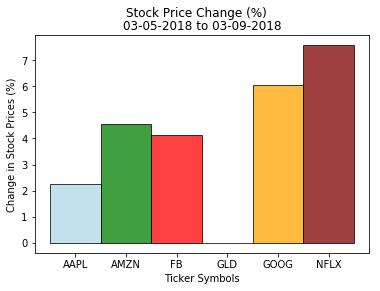

In [22]:
# Plot bar graph and assign appropriate parameters
plt.bar(x_axis, final_df["Percent_Diff"], width = 1, tick_label = x_labels,
        color = colors, alpha = 0.75, align = "edge", edgecolor = "black")

tick_locations = [i+0.5 for i in x_axis]
plt.xticks(tick_locations, ["AAPL", "AMZN", "FB", "GLD", "GOOG", "NFLX"])

# Chart Title, x-label and y-label
plt.suptitle("Stock Price Change (%)")
plt.title("03-05-2018 to 03-09-2018")
plt.xlabel("Ticker Symbols")
plt.ylabel("Change in Stock Prices (%)")

# Export and save Bar plot
plt.savefig("PriceChange.png")

# Print chart to the screen
plt.show()

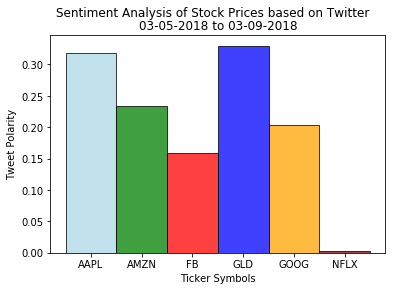

In [23]:
# Plot bar graph and assign appropriate parameters
plt.bar(x_axis, final_df["Compound"], width = 1, tick_label = x_labels,
        color = colors, alpha = 0.75, align = "edge", edgecolor = "black")

tick_locations = [i+0.5 for i in x_axis]
plt.xticks(tick_locations, ["AAPL", "AMZN", "FB", "GLD", "GOOG", "NFLX"])

# Chart Title, x-label and y-label
plt.suptitle("Sentiment Analysis of Stock Prices based on Twitter")
plt.title("03-05-2018 to 03-09-2018")
plt.xlabel("Ticker Symbols")
plt.ylabel("Tweet Polarity")

# Export and save Bar plot
plt.savefig("Sentiment.png")

# Print chart to the screen
plt.show()

In [24]:
corr = final_df["Percent_Diff"].corr(final_df["Compound"])
corr

-0.87405767248830535

In [40]:
x = final_df["Percent_Diff"]
y = final_df["Compound"]
fit = np.polyfit(x, y, 1)
fit_fn = np.poly1d(fit)
plt.plot(x, fit_fn(x), color = 'black')

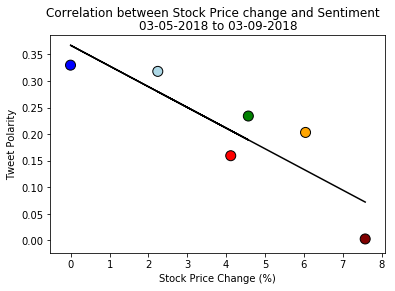

In [41]:
# Scatter Correlation plot
plt.scatter(final_df["Percent_Diff"], final_df["Compound"],
         s = 100, color = colors, edgecolor = "black")

plt.suptitle("Correlation between Stock Price change and Sentiment")
plt.title("03-05-2018 to 03-09-2018")
plt.xlabel("Stock Price Change (%)")
plt.ylabel("Tweet Polarity")

# Export and save scatter plot
plt.savefig("Correlation.png")

# Print chart to the screen
plt.show()

In [31]:
from scipy.stats import linregress
linregress(final_df["Percent_Diff"], final_df["Compound"])

LinregressResult(slope=-0.038921492210093805, intercept=0.36717446530246156, rvalue=-0.87405767248830535, pvalue=0.022793389572690944, stderr=0.010816748466719848)